In [1]:
import sys
import os
from pathlib import Path

scripts_dir = Path().resolve()
parent_dir = scripts_dir.parent
sys.path.insert(0, str(parent_dir))

import aeon
import aeon.io.api as api
from aeon.io import reader, video
from aeon.schema.dataset import exp02
from aeon.analysis.utils import visits, distancetravelled

import SSM
from SSM.ssm.plots import gradient_cmap, white_to_color_cmap

import cv2
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.dates import date2num, SecondLocator, DateFormatter

import numpy as np
import pandas as pd
import seaborn as sns

import scipy
import pyarrow

import torch

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import pymc3 as pm

import Functions.inference as inference
import Functions.kinematics as kinematics
import Functions.learning as learning

!ls /ceph/aeon

# Long, individual session
root = [Path("/ceph/aeon/aeon/data/raw/AEON2/experiment0.2")]

# Ensure root exists
if not np.all([path.exists() for path in root]):
    print("Cannot find root paths. Check path names or connection.")
    
Exp02Summary = api.load(root, exp02.Metadata).metadata[0].toDict()
Patch_Pos = [device['Regions']['ArrayOfPoint'] for device in Exp02Summary['Devices'] if device['Name'].startswith('ActivityPatch')]

subject_events = api.load(root, exp02.ExperimentalMetadata.SubjectState)
sessions = visits(subject_events[subject_events.id.str.startswith("BAA-")])

short_sessions = sessions.iloc[[4,16,17,20,23,24,25,26,28,29,30,31]]
long_sessions = sessions.iloc[[8, 10, 11, 14]]

aeon			 aeon_transfer.log  rmhzbm0  test2
aeon_transfer_final.log  db_dumps	    test


In [2]:
display(short_sessions)

,id,weight_enter,weight_exit,enter,exit,duration
4,BAA-1100700,26.3,26.3,2022-03-15 12:40:36.282139778,2022-03-15 15:56:55.801119804,0 days 03:16:19.518980026
16,BAA-1101818,26.2,26.7,2022-06-21 10:27:42.615139961,2022-06-21 13:15:50.564740181,0 days 02:48:07.949600220
17,BAA-1101819,25.4,26.4,2022-06-21 13:28:10.593659878,2022-06-21 16:34:29.241280079,0 days 03:06:18.647620201
20,BAA-1101818,26.4,28.0,2022-06-23 08:39:04.261089801,2022-06-23 11:14:46.121759892,0 days 02:35:41.860670091
23,BAA-1101818,26.9,27.8,2022-06-24 09:32:37.183360100,2022-06-24 12:29:54.365859985,0 days 02:57:17.182499885
24,BAA-1101823,27.9,27.9,2022-07-14 12:53:15.740799904,2022-07-14 16:35:05.846270084,0 days 03:41:50.105470180
25,BAA-1101821,25.0,26.0,2022-07-15 13:14:40.239679813,2022-07-15 15:47:44.568860054,0 days 02:33:04.329180241
26,BAA-1101819,25.7,27.1,2022-07-19 10:37:08.422299862,2022-07-19 16:04:43.376220226,0 days 05:27:34.953920364
28,BAA-1101818,26.7,29.5,2022-08-15 10:25:01.651199818,2022-08-15 13:04:50.849309921,0 days 02:39:49.198110103
29,BAA-1101819,27.5,30.0,2022-08-15 13:11:23.791259766,2022-08-15 16:10:27.350080013,0 days 02:59:03.558820247


In [3]:
display(long_sessions)

,id,weight_enter,weight_exit,enter,exit,duration
8,BAA-1100699,26.75,29.0,2022-03-29 13:11:37.277699947,2022-04-04 09:16:51.086110115,5 days 20:05:13.808410168
10,BAA-1100701,26.70,30.6,2022-04-04 15:54:07.945059776,2022-04-08 16:34:36.183650017,4 days 00:40:28.238590241
11,BAA-1100699,29.00,28.2,2022-04-20 11:51:24.997630119,2022-04-28 10:02:56.655809879,7 days 22:11:31.658179760
14,BAA-1100702,27.00,28.9,2022-05-03 11:08:12.660739899,2022-05-12 09:21:42.411650181,8 days 22:13:29.750910282


In [4]:
for i in range(12):
    title = 'ShortSession' + str(i)
    print(title)
    try:
        P = np.load('../Data/MouseKinematicParameters/' + title + 'Parameters.npz', allow_pickle=True)
        sigma_a, sigma_x, sigma_y, sqrt_diag_V0_value, B, Qe, m0, V0, Z, R = P['sigma_a'].item(), P['sigma_x'].item(), P['sigma_y'].item(), P['sqrt_diag_V0_value'].item(), P['B'], P['Qe'], P['m0'], P['V0'], P['Z'], P['R']
        print('sigma_a: ', sigma_a)
        print('sqrt_diag_V0: ', sqrt_diag_V0_value)
        print(" ")
    except FileNotFoundError: continue

ShortSession0
sigma_a:  19.04378318786621
sqrt_diag_V0:  8.884480746829285
 
ShortSession1
sigma_a:  8.943471908569336
sqrt_diag_V0:  -434.7187253948607
 
ShortSession2
sigma_a:  15.132633209228516
sqrt_diag_V0:  851.4570456902169
 
ShortSession3
sigma_a:  12.389060974121094
sqrt_diag_V0:  7.552517488276839
 
ShortSession4
sigma_a:  15.150012016296387
sqrt_diag_V0:  6.636295969288154
 
ShortSession5
sigma_a:  10.252096176147461
sqrt_diag_V0:  376.9970668684667
 
ShortSession6
sigma_a:  8.456497192382812
sqrt_diag_V0:  414.2603691775567
 
ShortSession7
sigma_a:  10.861308097839355
sqrt_diag_V0:  3.402446525911847
 
ShortSession8
sigma_a:  14.054520606994629
sqrt_diag_V0:  7.304333642642001
 
ShortSession9
sigma_a:  11.533198356628418
sqrt_diag_V0:  3.6607655605611584
 
ShortSession10
sigma_a:  11.28909969329834
sqrt_diag_V0:  7.390998496624566
 
ShortSession11
sigma_a:  14.494546890258789
sqrt_diag_V0:  6.2997167115489034
 


In [14]:
for i in range(4):
    title = 'LongSession' + str(i)
    print(title)
    try:
        P = np.load('../Data/MouseKinematicParameters/' + title + 'Parameters.npz', allow_pickle=True)
        sigma_a, sigma_x, sigma_y, sqrt_diag_V0_value, B, Qe, m0, V0, Z, R = P['sigma_a'].item(), P['sigma_x'].item(), P['sigma_y'].item(), P['sqrt_diag_V0_value'].item(), P['B'], P['Qe'], P['m0'], P['V0'], P['Z'], P['R']
        print('sigma_a: ', sigma_a)
        print('sqrt_diag_V0: ', sqrt_diag_V0_value)
        print(" ")
    except FileNotFoundError: continue

LongSession0
sigma_a:  10.945871353149414
sqrt_diag_V0:  3.4561682598168413
 
LongSession1
sigma_a:  10.234971046447754
sqrt_diag_V0:  3.307025994777439
 
LongSession2
LongSession3


In [9]:
Manual = np.load('../Data/MouseKinematicParameters/ShortSessions_LL_Manual.npy', allow_pickle=True)
Learned = np.load('../Data/MouseKinematicParameters/ShortSessions_LL_Learned.npy', allow_pickle=True)

In [10]:
Manual

array([  -50.75167087,   -33.7864688 ,   -55.46295733,   -91.97254088,
         -28.98819496,   -42.7243799 ,   -42.29880334, -1330.15819116,
         -37.5178155 ,   -46.46203257,   -45.12113761,   -39.93614478])

In [11]:
Learned

array([-8.49596558e+00, -1.15775857e+08, -2.43812176e+08, -2.26820320e+01,
       -4.62534443e+01, -3.12871407e+08, -9.96827818e+08, -6.83397822e+04,
       -1.48326655e+01, -5.12410537e+01, -7.04064332e+00, -1.37911573e+01])

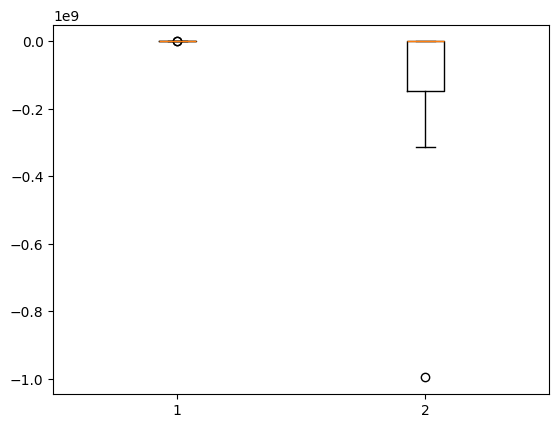

In [13]:
plt.boxplot(np.array([Manual, Learned]).T)
plt.xlabel('')
plt.show()